# Machine Learning

Nesse notebook, iremos:
* Preparar os dados
* Selecionar e treinar alguns modelos de machine learning
* Aperfeiçoar o sistema

In [1]:
# Importar os pacotes necessários
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from boruta import BorutaPy

from scipy import stats

# Código que transforma o csv em um dataframe pandas
pd.set_option("display.max_columns", None)
df_train = pd.read_csv('train_set.csv')

## Preparação dos dados

In [2]:
# Criar uma cópia do conjunto de dados
df_dev = df_train.copy()

### Limpeza dos dados

In [3]:
# 1. Corrigir ou remover outliers
def exclui_outliers(DataFrame, col_name):
    '''Função que utiliza a regra:
    Q1 - 1,5 x IQR (ou -2,7 sigma) / Q3 + 1,5 x IQR (ou 2,7 sigma) para excluir outliers.
    A função pega todos os valores que estão fora desse intervalo e o substituem para "nan".
    
    :param DataFrame: (dataframe) 
    Dataframe que você quer aplicar a regra.
    
    :param col_name: (series)
    Coluna(s) quantitativas contínuas que você quer eliminar os outliers.
    Deve ser passada entre aspas ao chamar a função.
    
    :return: (dataframe)
    Dataset com as respectivas colunas sem os possíveis outliers.
    '''
    intervalo = 2.7*DataFrame[col_name].std()
    media = DataFrame[col_name].mean()
    DataFrame.loc[DataFrame[col_name] < (media - intervalo), col_name] = np.nan
    DataFrame.loc[DataFrame[col_name] > (media + intervalo), col_name] = np.nan

In [4]:
# Eliminar outliers
numerical_cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price']
for col in numerical_cols:
    exclui_outliers(df_dev, col)

In [5]:
# 2. Preencher ou remover valores ausentes
df_dev.dropna(inplace=True)

#### df_dev.describe()

### Feature Engineering - Parte I (preparação para o feature selection)

In [6]:
# 1. Separar as variáveis independentes da variável dependente
df_sel_X = df_dev.drop('price', axis=1)
df_sel_y = df_dev['price']

In [7]:
# 2. Criar uma nova coluna com a transformação mapeada na etapa de EDA

# Função que irá criar a nova coluna
def combined_attributes_host_since(X, column_name):
    '''Função que faz um feature engineering no dataset, onde é criado uma nova coluna.
    Essa coluna é criada a partir da subtração de uma coluna de data pré-existente e da data 
    atual (do dia de hoje), portanto, o resultado é uma nova coluna que representa a quantidade de dias
    entre a data existente menos a data atual.
    No final a coluna de data pré-existente é excluída.
    
    :param X: (dataframe)
    Dataframe a ser feito o feature engineering.
    
    :param column_name: (series)
    Coluna de data pré-existente a ser subtraída da data atual. 
    Deve ser passada entre aspas ao chamar a função.
    
    :return: (dataframe)
    Dataset com o feature engineering implementado e a coluna data pré-existente excluída.
    '''
    X.host_since = pd.to_datetime(X[column_name], infer_datetime_format=True)
    X['host_since_days'] = (X[column_name] - pd.Timestamp.now().normalize()).astype(str)
    X.host_since_days = X.host_since_days.str.replace('-', '').str.replace('days', '').astype('int64')
    X.drop(column_name, axis=1, inplace=True)

# Execução da função
combined_attributes_host_since(df_sel_X, 'host_since')

In [8]:
# 3. Transformar as variáveis qualitativas para numéricas
df_sel_X = pd.get_dummies(df_sel_X, drop_first=True)

### Feature Selection

#### 1. Mutual info regression

A ideia desse método é: Se X e y são independentes, então nenhuma informação sobre y pode ser obtida conhecendo X ou vice-versa. Nesse caso, sua informação mútua é 0. Em contrapartida, se X é uma função determinística de y, então podemos determinar X de y e y de X, com informação mútua de 1.

Quanto menor o valor, menos a variável descreve a relação com o alvo!

A vantagem de usar informações mútuas sobre o F-Test é que ele se dá bem com a relação não linear entre as variáveis de recursos e do alvo.

**Pela definição do Sklearn:**

A informação mútua (MI) entre duas variáveis aleatórias é um valor não negativo, que mede a dependência entre as variáveis. É igual a zero se e somente se duas variáveis aleatórias são independentes, e valores mais altos significam maior dependência.

A função baseia-se em métodos não paramétricos baseados na estimativa de entropia de distâncias de k-vizinhos mais próximos.

['host_response_rate',
 'host_acceptance_rate',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'reviews_per_month',
 'host_since_days',
 'room_type_Private room']

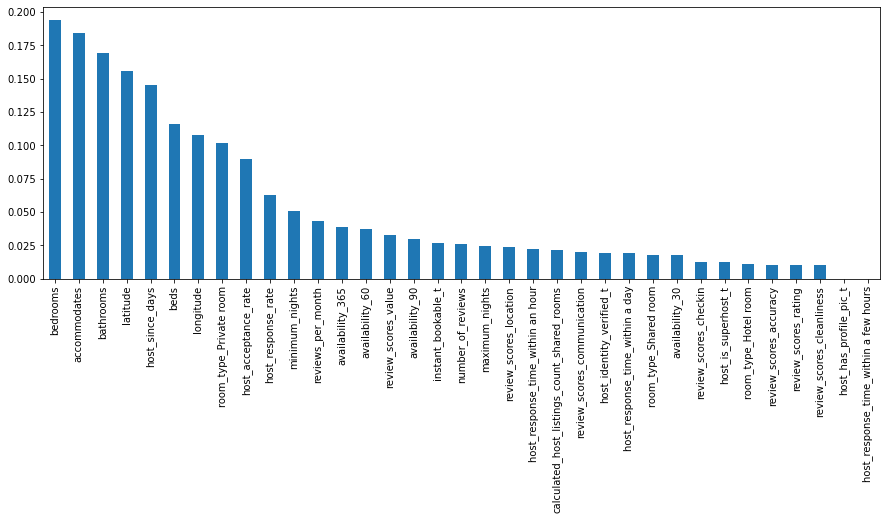

In [9]:
# Função que retorna os valores da informação mútua
def select_features_mi(X, y, percentile):
    '''Função que faz um feature selection do dataset.
    A função utiliza o método mutual info regression do SKlearn.
    Deve-se dividir o dataset em variáveis independentes(X) e variável dependente(y).
    
    :param X: (dataframe) 
    Dataframe com o conjunto de variáveis independentes.
    
    :param y: (series)
    Coluna com a variável dependente.
    
    :param percentile: (number)
    Valor do percentil a ser passado para que a função filtre a quantidade 
    de colunas que você queira selecionar.
    
    :return: (list/graph)
    Lista com o nome das variáveis selecionadas como as mais "importantes".
    Gráfico com a comparação de todas as variáveis.
    '''
    # Retorna todas as informações do MI entre as variáveis
    mutual_info = mutual_info_regression(X, y)
    mutual_info = pd.Series(mutual_info)
    mutual_info.index = X.columns
    lst_mi_scores = mutual_info.sort_values(ascending=False)
    graph_mi_scores = mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))

    # Aplicando o metodo "select percentile"
    sel_ = SelectPercentile(mutual_info_regression, percentile=percentile).fit(X, y)
    selected_mi_variables = list(X.columns[sel_.get_support()])
    return selected_mi_variables

# Aplicando a função do MI
select_features_mi(df_sel_X, df_sel_y, 30)

#### 2. f_regression

Análise de variância (ANOVA) é uma técnica estatística utilizada para verificar se as médias de dois ou mais grupos são significativamente diferentes entre si. Verifica-se o impacto de um ou mais fatores comparando as médias de diferentes amostras.

**Pela definição do Sklearn:**

Testes de regressão linear univariada retornando a estatística F e os valores p. 

['host_acceptance_rate',
 'latitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'number_of_reviews',
 'reviews_per_month',
 'host_since_days',
 'room_type_Hotel room',
 'room_type_Private room']

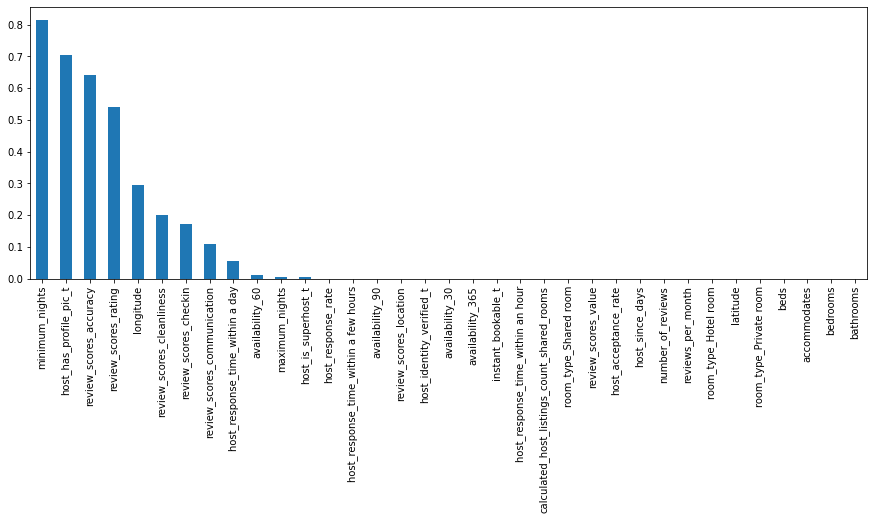

In [10]:
# Função que retorna os resultados da anova
def select_features_anova(X, y, percentile):
    '''Função que faz um feature selection do dataset.
    A função utiliza o método f_regression do SKlearn.
    Deve-se dividir o dataset em variáveis independentes(X) e variável dependente(y).
    
    :param X: (dataframe) 
    Dataframe com o conjunto de variáveis independentes.
    
    :param y: (series)
    Coluna com a variável dependente.
    
    :param percentile: (number)
    Valor do percentil a ser passado para que a função filtre a quantidade 
    de colunas que você queira selecionar.
    
    :return: (list/graph)
    Lista com o nome das variáveis selecionadas como as mais "importantes".
    Gráfico com a comparação de todas as variáveis.
    '''
    # Retorna todas as informações do método
    univariate = f_regression(X, y)
    univariate = pd.Series(univariate[1])
    univariate.index = X.columns
    lst_anova_scores = univariate.sort_values(ascending=False, inplace=True)
    graph_anova_scores = univariate.sort_values(ascending=False).plot.bar(figsize=(15,5)) # eixo y do gráfico é relativo aos p-values
    
    # Aplicando o metodo "select percentile"
    sel_ = SelectPercentile(f_regression, percentile=percentile).fit(X, y)
    selected_anova_variables = list(X.columns[sel_.get_support()])
    return selected_anova_variables

# Aplicando a função da anova
select_features_anova(df_sel_X, df_sel_y, 30)

#### 3. Baseado em árvore

Este é um método incorporado. Os métodos incorporados usam algoritmos que possuem métodos de seleção de recursos integrados.

Também podemos usar RandomForest para selecionar recursos com base na importância do recurso.

Calculamos a importância do recurso usando impurezas de nó em cada árvore de decisão. Na floresta aleatória, a importância final do recurso é a média de todas as importâncias dos recursos da árvore de decisão.

In [11]:
# Função que retorna a seleção de features baseado em árvores

# treinando e selecionando as features pelo método
def select_features_rf(X, y, num_feats):
    '''Função que faz um feature selection do dataset.
    A função utiliza o método incorporado do random forest do SKlearn.
    Deve-se dividir o dataset em variáveis independentes(X) e variável dependente(y).
    
    :param X: (dataframe) 
    Dataframe com o conjunto de variáveis independentes.
    
    :param y: (series)
    Coluna com a variável dependente.
    
    :param num_feats: (number)
    Número que informa a quantidade de colunas que você quer selecionar
    
    :return: (list)
    Lista com o nome das variáveis selecionadas como as mais "importantes".
    '''
    # treinando o modelo
    embeded_rf_selector = SelectFromModel(RandomForestRegressor(), max_features=num_feats)
    embeded_rf_selector.fit(X, y)
    
    # extraindo as features mais importamtes
    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features')
    return embeded_rf_feature

# Aplicando a função do método de árvores
select_features_rf(df_sel_X, df_sel_y, 11)

11 selected features


['host_acceptance_rate',
 'latitude',
 'longitude',
 'bathrooms',
 'bedrooms',
 'availability_90',
 'availability_365',
 'reviews_per_month',
 'host_since_days',
 'host_response_time_within a few hours',
 'host_is_superhost_t']

#### 4. [Boruta](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a)

In [12]:
# Função que aplica o método do boruta
def select_features_boruta(X, y):
    '''Função que faz um feature selection do dataset.
    A função utiliza o método do boruta. Para mais informações, acesse o link:
    https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a
    Deve-se dividir o dataset em variáveis independentes(X) e variável dependente(y).
    
    :param X: (dataframe or numpy array) 
    Dataframe ou array com o conjunto de variáveis independentes.
    
    :param y: (series or numpy array)
    Coluna ou array com a variável dependente.

    :return: (list)
    Lista com o nome das variáveis selecionadas como as mais "importantes" (green area).
    Lista com o nome das variáveis selecionadas como "promissoras" (blue area).
    '''
    # initialize Boruta
    forest = RandomForestRegressor(
       n_jobs = -1, 
       max_depth = 5
    )
    boruta = BorutaPy(
       estimator = forest, 
       n_estimators = 'auto',
       max_iter = 100 # number of trials to perform
    )
    # fit Boruta (it accepts np.array, not pd.DataFrame)
    boruta.fit(np.array(X), np.array(y))
    
    # print results
    green_area = X.columns[boruta.support_].to_list()
    blue_area = X.columns[boruta.support_weak_].to_list()
    print('features in the green area:', green_area)
    print('features in the blue area:', blue_area)

# Aplicando a função do boruta
select_features_boruta(df_sel_X, df_sel_y)

features in the green area: ['bathrooms', 'bedrooms', 'reviews_per_month', 'host_response_time_within a few hours', 'host_is_superhost_t', 'room_type_Hotel room']
features in the blue area: ['latitude', 'longitude', 'availability_365']


Após executar todos os métodos, finalmente vamos selecionar as variáveis que irão alimentar o modelo de machine learning. São elas: 'host_acceptance_rate', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'host_since_days', 'room_type_Hotel room', 'room_type_Private room', 'reviews_per_month', 'availability_365', 'host_is_superhost_t', 'host_response_time_within a few hours'

In [13]:
# Seleção das variáveis
X = df_sel_X[['latitude', 'longitude', 'accommodates', 'bathrooms', 
              'bedrooms', 'beds', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room',
              'availability_365']]
#               'host_acceptance_rate', 'host_since_days', 'reviews_per_month', 'host_is_superhost_t', 'host_response_time_within a few hours'
y = df_sel_y.copy()

### Feature Engineering - Parte II (preparação para o modelo de ML)

In [14]:
# 1. Criar pipelines para fazer as transformações necessárias

# 1.1 Separar as variáveis qualitativas das quantitativas
continuous_columns = selector(dtype_exclude=['uint8'])
qualitative_columns = selector(dtype_include=['uint8'])

continuous_columns = continuous_columns(X)
qualitative_columns = qualitative_columns(X)

# 1.2 Pipeline das variáveis numéricas
num_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(2)),
    ('std_scaler', StandardScaler())

])

# 1.4 Aplicar as respectivas transformações com o metodo column transformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, continuous_columns)],
     remainder='passthrough')

## Pré-Seleção de Modelos Promissores

Nessa etapa iremos apenas criar um baseline e depois trabalhar uma rede neural. Faremos o baseline com um modelo mais simples, uma regressão linear e criaremos uma rede neural para comparar o desempenho dos dois.

### Baseline

In [15]:
# 1. Anexando o regressor ao pipeline de pré-processamento
lin_reg = Pipeline(
    steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())]
)

# 2. Aplicando a validação cruzada
lin_scores = cross_validate(lin_reg, X, y, scoring=('r2', 'neg_mean_squared_error'), cv = 5, return_train_score=True)

# Treino e teste RMSE
lin_train_rmse_scores = np.sqrt(-lin_scores['train_neg_mean_squared_error'])
lin_test_rmse_scores = np.sqrt(-lin_scores['test_neg_mean_squared_error'])

# Treino e teste R2
lin_train_r2_scores = lin_scores['train_r2']
lin_test_r2_scores = lin_scores['test_r2']


# Função de avaliação dos resultados
def display_scores(scores):
    print('Scores:', scores)
    print('Média:', scores.mean())
    print('Desvio Padrão:', scores.std())

In [16]:
# Avaliação do baseline RMSE
display_scores(lin_train_rmse_scores) 
display_scores(lin_test_rmse_scores) 

Scores: [389.53279769 378.31842433 356.07298856 370.23968491 379.60821623]
Média: 374.7544223469739
Desvio Padrão: 11.171755684309964
Scores: [314.08130692 365.40539837 444.89154904 396.18544577 358.960206  ]
Média: 375.9047812202404
Desvio Padrão: 43.33584459135072


In [17]:
# Avaliação do baseline R2
display_scores(lin_train_r2_scores) 
display_scores(lin_test_r2_scores) 

Scores: [0.2756411  0.28213639 0.29357557 0.28270653 0.28893925]
Média: 0.28459976793041786
Desvio Padrão: 0.006153153039533785
Scores: [0.31571492 0.27661    0.25027908 0.27894341 0.24844978]
Média: 0.27399943578371
Desvio Padrão: 0.024441275279115205


### Outros modelos promissores

In [18]:
# Função para treinar e avaliar diversos modelos
def run_regressor_models(X, y, cv, scoring):
    '''Função que treina os seguintes modelos de machine learning:
    DecisionTreeRegressor, RandomForestRegressor, svm, SGDRegressor,
    GradientBoostingRegressor, ElasticNet, MLPRegressor.
    A função aplica a validação cruzada no conjunto de dados e retorna a média
    e o desvio-padrão da métrica selecionada no conjunto de treino e validação.
    As únicas métricas ativas são RMSE e R2.
    
    :param X: (dataframe or numpy array) 
    Dataframe ou array com o conjunto de variáveis independentes.
    
    :param y: (series or numpy array)
    Coluna ou array com a variável dependente.
    
    :param cv: (int)
    Determina a estratégia de divisão de validação cruzada.
    
    :param scoring: (str)
    Estratégia para avaliar o desempenho do modelo de validação cruzada no conjunto de validação.
    Deve ser passada entre aspas ao chamar a função.

    :return: (dataframe)
    Dataframe com os modelos, média e desvio-padrão no conjunto de treino e validação.
    '''
    # 1. Instanciar os modelos
    tree_reg = DecisionTreeRegressor()
    rf_reg = RandomForestRegressor()
    svm_reg = svm.SVR()
    sgd_reg = SGDRegressor()
    gbr_reg = GradientBoostingRegressor()
    elastic_net = ElasticNet()
    mlp_reg = MLPRegressor()

    # 2. Treinar e avaliar os modelos
    df_result = pd.DataFrame()
    
    for model in (tree_reg, rf_reg, svm_reg, sgd_reg, gbr_reg, elastic_net, mlp_reg):
        reg = Pipeline(
            steps=[('preprocessor', preprocessor), ('regressor', model)]
        )
        scores = cross_validate(reg, X, y, return_train_score=True,
                                scoring=scoring, cv=cv)
        
        # Treino e teste RMSE
        if scoring == 'neg_mean_squared_error':
            train_rmse_scores = np.sqrt(-scores['train_score'])
            test_rmse_scores = np.sqrt(-scores['test_score'])
            mean_train = train_rmse_scores.mean()
            mean_test = test_rmse_scores.mean()
            std_train = train_rmse_scores.std()
            std_test = test_rmse_scores.std()
    
        # Treino e teste R2
        if scoring == 'r2':
            train_r2_scores = scores['train_score']
            test_r2_scores = scores['test_score']
            mean_train = train_r2_scores.mean()
            mean_test = test_r2_scores.mean()
            std_train = train_r2_scores.std()
            std_test = test_r2_scores.std()

        # 3. Criar dataset final
        df_result = df_result.append({
                                      'MODEL': model, #'TRAIN_SCORES': train_rmse_scores, 'VAL_SCORES': test_rmse_scores,
                                      'MEAN_TRAIN_SCORES': mean_train, 'MEAN_TEST_SCORES': mean_test, 'STD_TRAIN_SCORES': std_train, 
                                      'STD_TEST_SCORES': std_test, 
                                      }, ignore_index=True)

    return df_result

In [19]:
run_regressor_models(X, y, 5, 'r2')

,MODEL,MEAN_TRAIN_SCORES,MEAN_TEST_SCORES,STD_TRAIN_SCORES,STD_TEST_SCORES
0,DecisionTreeRegressor(),0.999938,-0.251550,0.000032,0.270197
1,RandomForestRegressor(),0.899284,0.339640,0.003179,0.068475
2,SVR(),0.085667,0.088421,0.004913,0.025160
3,SGDRegressor(),0.248745,0.241079,0.011993,0.045622
4,GradientBoostingRegressor(),0.601246,0.362344,0.012495,0.074741
5,ElasticNet(),0.217726,0.221036,0.009802,0.047592
6,MLPRegressor(),0.262298,0.254901,0.009883,0.052495


## Aperfeiçoar o modelo

In [20]:
# Tunning de hiperparâmetros
# 1. Instanciar o pipeline
final_model = Pipeline(
    steps=[('preprocessor', preprocessor), ('elastic_net', ElasticNet())]
)

# 2. Intervalo de parâmetros a ser testado
param_grid = {'elastic_net__alpha': [0.01, 0.1, 1, 10], 'elastic_net__l1_ratio': [0, 0.5, 1]}

# 3. Aplicar e treinar a pesquisa de grade com validação cruzada
grid_search = GridSearchCV(final_model, param_grid, cv = 5, scoring = 'r2',
                           return_train_score = True)
grid_search.fit(X, y)

# Obtendo os melhores parâmetros para o elastic net
print('Os melhores hiperparâmetros encontrados foram:', grid_search.best_params_)

Os melhores hiperparâmetros encontrados foram: {'elastic_net__alpha': 0.1, 'elastic_net__l1_ratio': 1}


In [21]:
# Obtendo os melhores scores e parâmetros para o random forest
cvres = grid_search.cv_results_
for mean_train_score, mean_test_score, params in zip(cvres['mean_train_score'], cvres['mean_test_score'], cvres['params']):
#     print(np.sqrt(-mean_score), params)
    print(mean_train_score, mean_test_score, params)

0.25146128182265814 0.2509035935941737 {'elastic_net__alpha': 0.01, 'elastic_net__l1_ratio': 0}
0.2580066156953218 0.25614407490375823 {'elastic_net__alpha': 0.01, 'elastic_net__l1_ratio': 0.5}
0.27010664306920873 0.2628840611870168 {'elastic_net__alpha': 0.01, 'elastic_net__l1_ratio': 1}
0.23054796747990633 0.23293810204074283 {'elastic_net__alpha': 0.1, 'elastic_net__l1_ratio': 0}
0.23643983542051786 0.23824364685448546 {'elastic_net__alpha': 0.1, 'elastic_net__l1_ratio': 0.5}
0.270021554070773 0.2630006109316557 {'elastic_net__alpha': 0.1, 'elastic_net__l1_ratio': 1}
0.21270000012211487 0.2162749967234438 {'elastic_net__alpha': 1, 'elastic_net__l1_ratio': 0}
0.21772597663248097 0.2210360520751614 {'elastic_net__alpha': 1, 'elastic_net__l1_ratio': 0.5}
0.26295104359889393 0.2583117405833827 {'elastic_net__alpha': 1, 'elastic_net__l1_ratio': 1}
0.16611169821250196 0.16998932961272534 {'elastic_net__alpha': 10, 'elastic_net__l1_ratio': 0}
0.18495364090705607 0.18893860137253443 {'elast

## Salvar o modelo

In [22]:
def save_model(model, model_filepath):
    '''Function that saves our machine learning model.
    
    :param model: trained model with the best estimators.
    :param model_filepath: name of the file that the model will have. Example: lgbm_model.pkl
    
    :return: saved model file
    '''
    # save best model
    best_model = joblib.dump(model, model_filepath)
    return best_model

save_model(grid_search.best_estimator_, 'elastic_net.pkl')

['elastic_net.pkl']

## Avaliar o modelo no conjunto de testes

In [23]:
# 1. Importar o conjunto de dados de testes
test_set = pd.read_csv('test_set.csv')
df_test = test_set.copy()

In [24]:
# 2. Corrigir ou remover outliers
for col in numerical_cols:
    exclui_outliers(df_test, col)

In [25]:
# 3. Preencher ou remover valores ausentes
df_test.dropna(inplace=True)

In [26]:
# 4. Separar as variáveis independentes da variável dependente
X_test = df_test.drop('price', axis=1)
y_test = df_test['price']

In [27]:
# 5. Transformar as variáveis qualitativas para numéricas
X_test = pd.get_dummies(X_test, drop_first=True)

In [28]:
# 6. Seleção das variáveis
X_test = X_test[['latitude', 'longitude', 'accommodates', 'bathrooms', 
                 'bedrooms', 'beds', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room',
                 'availability_365']]

In [29]:

def predict_evaluate(best_estimator, X_test, y_test, confidence_level):
    '''Função que faz novas predições e avalia o resultado no conjunto de testes.
    As únicas métricas ativas são RMSE e R2.
    
    :param best_estimator: (machine learning models or SKlearn pipeline) 
    Parâmetros do modelo de machine learning um pipeline do SKlearn.
    
    :param X_test: (dataframe or numpy array)
    Dataframe ou array com o conjunto de dados independente.
    
    :param y_test: (series or numpy array)
    Coluna ou vetor com o conjunto de dados da variável alvo.
    
    :param confidence_level: (number)
    Nível de confiança que você queira nos seus resultados de avaliação do RMSE.
    Geralmente varia entre 0.90, 0.95 e 0.99.

    :return: 
    print dos resultados do RMSE, R2 e do intervalo de confiança para o RMSE.
    '''
    # Avaliar o modelo final no conjunto de teste
    final_model = best_estimator

    # Fazer predições com os dados de teste
    final_predictions = final_model.predict(X_test)

    # Avaliar as predições nos dados de teste
    final_mse = mean_squared_error(y_test, final_predictions)
    final_rmse = np.sqrt(final_mse)
    print('O RMSE final é:', final_rmse)

    final_r2 = r2_score(y_test, final_predictions)
    print('O R2 final é:', final_r2)
    
    # Intervalo de confiança para o erro de generalização
    confidence = confidence_level
    squared_errors = (final_predictions - y_test) ** 2
    confidence_interval = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                                                   loc = squared_errors.mean(),
                                                   scale = stats.sem(squared_errors)))
    print('O intervalo de confiança para o RMSE é:', confidence_interval)
    
predict_evaluate(grid_search.best_estimator_, X_test, y_test, 0.95)

O RMSE final é: 328.6042260770759
O R2 final é: 0.313832129298488
O intervalo de confiança para o RMSE é: [230.31143138 403.63116749]
